# Markstein lengths from Cantera using Eq. (31)

Standalone notebook (no YAML configs). Uses the Burke H2 mechanism and a 1D freely propagating flame to compute
Markstein lengths for curvature and strain as a function of non-dimensional temperature (T/Tu).

Equation (31) from Giannakopoulos et al. (Combustion and Flame 208, 2019):

$$
\bar{S}_d^* = S_L - L_{str}^* K_s - L_{cur}^* \kappa S_L
$$
$$
\begin{aligned}
L_{str}^* &= \left[\alpha \int_{1}^{\tilde{T}^*} \frac{\tilde{\lambda}(x)}{x} \, dx - \int_{\tilde{T}^*}^{\sigma} \frac{\tilde{\lambda}(x)}{x-1} \, dx\right] \\
L_{cur}^* &= \left[\alpha \int_{1}^{\tilde{T}^*} \frac{\tilde{\lambda}(x)}{x} \, dx\right]
\end{aligned}
$$

with $x = T/T_u$, $\tilde{\lambda} = \lambda/\lambda_u$, $\sigma = \rho_u/\rho_b$.
The coefficient $\alpha$ is obtained from Eq. (30) using an effective activation energy estimate.

Notes/assumptions:
- Zel'dovich number uses the paper's definition: $\beta = E (T_a - T_u) / (R T_a^2)$, with $E$ estimated from a local Arrhenius fit.
- Lean mixture: $Le_{\mathrm{eff}}$ is approximated by the fuel Lewis number at unburned conditions.


For reference, the coefficient used in this notebook are:

Eq. (30) :
$$
\alpha = \frac{\sigma}{\sigma - 1} \int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x}\,dx
+ \frac{\beta}{2} \frac{Le_{\mathrm{eff}} - 1}{\sigma - 1}
\int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x} \ln\left(\frac{\sigma - 1}{x - 1}\right)\,dx
$$


In [13]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cantera as ct

# ---------------------------
# User settings
# ---------------------------
def find_mech_path() -> Path:
    candidates = [
        Path.cwd() / "flamekit/chemical_mech/BurkeH2.yaml",
        Path.cwd().parent / "flamekit/chemical_mech/BurkeH2.yaml",
    ]
    for path in candidates:
        if path.is_file():
            return path
    raise FileNotFoundError("BurkeH2.yaml not found under flamekit/chemical_mech")

MECH_PATH = find_mech_path()
PHI = 0.4
T_U = 298.0
P_U = ct.one_atm
FUEL = "H2"
OXIDIZER = "O2:1.0, N2:3.76"

WIDTH = 400 * 2.453026e-05  # m
REFINE_CRIT = dict(ratio=3, slope=0.06, curve=0.12)


In [14]:
def solve_flame(phi: float) -> ct.FreeFlame:
    gas = ct.Solution(str(MECH_PATH))
    gas.TP = T_U, P_U
    gas.set_equivalence_ratio(phi, fuel=FUEL, oxidizer=OXIDIZER)

    flame = ct.FreeFlame(gas, width=WIDTH)
    flame.set_refine_criteria(**REFINE_CRIT)
    flame.solve(loglevel=1, auto=True)
    return flame


def estimate_activation_energy(flame: ct.FreeFlame) -> tuple[float, float]:
    # Effective activation energy from ln(qdot) vs 1/T near peak heat release
    T = flame.T
    qdot = flame.heat_release_rate
    qdot = np.clip(qdot, 1e-30, None)
    idx_peak = int(np.argmax(qdot))

    window = 8
    i0 = max(0, idx_peak - window)
    i1 = min(len(T), idx_peak + window + 1)
    T_w = T[i0:i1]
    q_w = qdot[i0:i1]
    x = 1.0 / T_w
    y = np.log(q_w)
    coef = np.polyfit(x, y, 1)
    slope = coef[0]
    E_a_eff = -slope * ct.gas_constant

    T_ad = float(T.max())
    return float(E_a_eff), T_ad


def lewis_numbers_unburned(phi: float) -> dict:
    gas = ct.Solution(str(MECH_PATH))
    gas.TP = T_U, P_U
    gas.set_equivalence_ratio(phi, fuel=FUEL, oxidizer=OXIDIZER)
    k_u = gas.thermal_conductivity
    rho_u = gas.density
    cp_u = gas.cp_mass
    d_th_u = k_u / (rho_u * cp_u)

    d_mix = gas.mix_diff_coeffs
    i_fuel = gas.species_index(FUEL)
    i_ox = gas.species_index("O2")

    le_f = d_th_u / d_mix[i_fuel]
    le_o = d_th_u / d_mix[i_ox]
    return {
        "Le_fuel": float(le_f),
        "Le_oxidizer": float(le_o),
    }


In [15]:
flame = solve_flame(PHI)

T = flame.T
T_left = float(T[0])
T_right = float(T[-1])
rho = flame.density
k = flame.thermal_conductivity
cp = flame.cp_mass

S_L = float(flame.velocity[0])
rho_u = float(rho[0])
rho_b = float(rho[-1])
sigma = rho_u / rho_b

k_u = float(k[0])
d_th_u = k_u / (rho_u * float(cp[0]))
l_f = d_th_u / S_L

E_eff, T_ad = estimate_activation_energy(flame)
beta = E_eff * (T_ad - T_U) / (ct.gas_constant * T_ad * T_ad)
lewis = lewis_numbers_unburned(PHI)
le_eff = lewis["Le_fuel"]  # lean mixture approximation

print(f"S_L = {S_L:.6f} m/s")
print(f"sigma = {sigma:.4f}")
print(f"l_f = {l_f:.6e} m")
print(f"E_eff (effective) = {E_eff:.3e} J/mol")
print(f"beta (paper) = {beta:.3f}")
print(f"Le_fuel = {lewis['Le_fuel']:.3f}, Le_oxidizer = {lewis['Le_oxidizer']:.3f}")

# Non-dimensional temperature
x = T / T_U
progress = (T - T_left) / (T_right - T_left)
lam_tilde = k / k_u

# Remove values too close to x=1 to avoid singularities
eps = 1e-4
mask = x > (1.0 + eps)
x = x[mask]
lam_tilde = lam_tilde[mask]

# Ensure monotonic increasing in x
order = np.argsort(x)
x = x[order]
lam_tilde = lam_tilde[order]
progress = progress[mask][order]


def cumtrapz(y: np.ndarray, x: np.ndarray) -> np.ndarray:
    dx = np.diff(x)
    area = 0.5 * (y[1:] + y[:-1]) * dx
    return np.concatenate(([0.0], np.cumsum(area)))

# Integrals for Eq. (31)
f1 = lam_tilde / x
I1 = cumtrapz(f1, x)

f2 = lam_tilde / (x - 1.0)
I2_cum = cumtrapz(f2, x)
I2_total = float(I2_cum[-1])
I2 = I2_total - I2_cum

# Eq. (30) auxiliary integral
f2_ln = lam_tilde / x * np.log((sigma - 1.0) / (x - 1.0))
I2_ln = cumtrapz(f2_ln, x)
I2_ln_total = float(I2_ln[-1])

I1_total = float(I1[-1])
alpha = (sigma / (sigma - 1.0)) * I1_total + 0.5 * beta * (le_eff - 1.0) / (sigma - 1.0) * I2_ln_total

L_str = (alpha * I1 - I2)
L_cur = (alpha * I1)

# Save Markstein lengths vs progress variable
out_dir = Path.cwd() / "data" / "Markstein lengths"
out_dir.mkdir(parents=True, exist_ok=True)
p_atm = P_U / ct.one_atm
out_name = f"markstein_phi_{PHI:.2f}_Tu_{T_U:.0f}K_P_{p_atm:.2f}atm.csv"
out_path = out_dir / out_name
df_out = pd.DataFrame({
    "progress": progress,
    "T": T[mask][order],
    "L_cur": L_cur,
    "L_str": L_str,
})
df_out.to_csv(out_path, index=False)



************ Solving on 8 point grid with energy equation enabled ************

..............................................................................

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 5.063e-05  log(ss)= 5.305     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 4.055e-05  log(ss)= 5.534     

Attempt Newton solution of steady-state problem.
Newton steady-state solve succeeded.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.019624207999999997 m
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 3 4 5 6 7 
    to resolve H H2 H2O H2O2 HO2 N2 O O2 OH T velocity 
##############################################################################

********

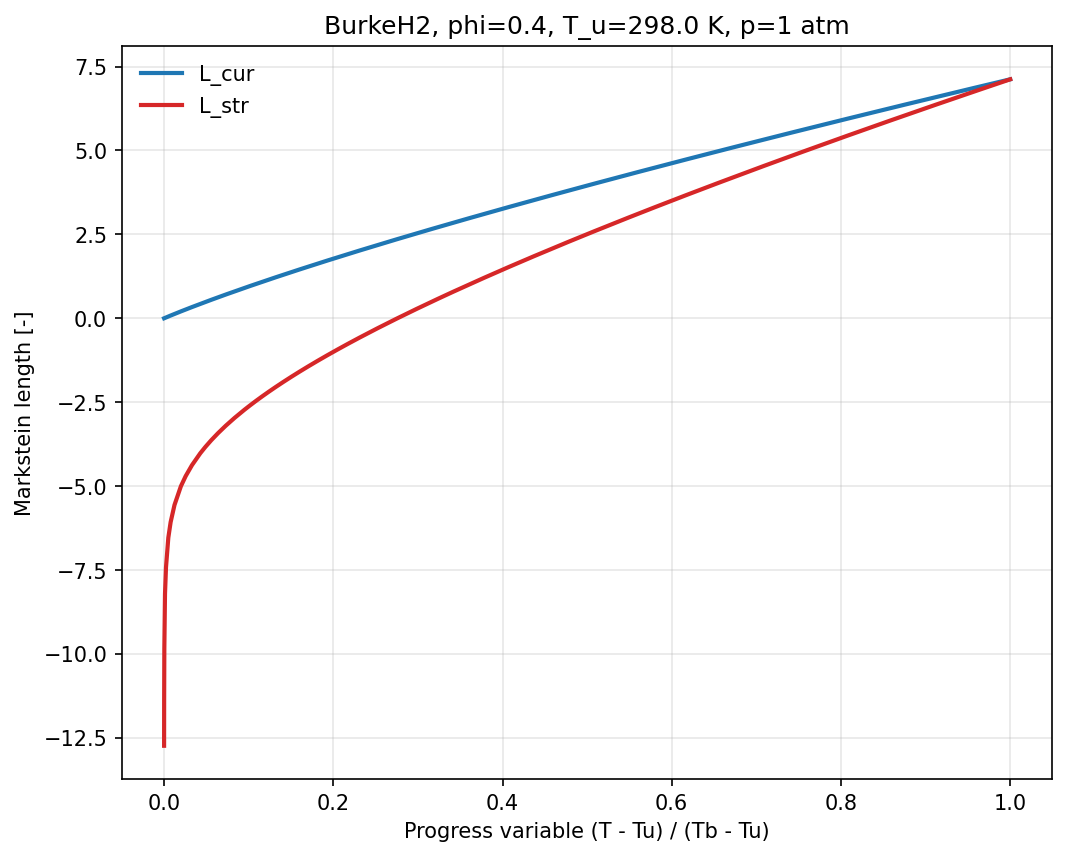

In [16]:
# Plot Markstein lengths vs progress variable
fig, ax = plt.subplots(figsize=(7.0, 5.6), dpi=150, constrained_layout=True)
ax.plot(progress, L_cur, label="L_cur", color="#1f77b4", linewidth=2.0)
ax.plot(progress, L_str, label="L_str", color="#d62728", linewidth=2.0)
ax.set_xlabel("Progress variable (T - Tu) / (Tb - Tu)")
ax.set_ylabel("Markstein length [-]")
ax.set_title(f"BurkeH2, phi={PHI}, T_u={T_U} K, p=1 atm")
ax.grid(True, alpha=0.3)
ax.legend(frameon=False)
plt.show()
